#### ReadMe
This exercise is about Bitcoin. The data records all trades at Coinbase in March 2020. Unluckily, we only see market price and quantity traded. But the data gives the indicator of “BUY” or “SELL” on the taker side. This indicator is not available for most of equity trades dataset.

#### Questions: 

* Calculate Kyle’s lambda (market impact) for all the data in March
* Calculate Kyle’s lambda (market impact), volume, signed volume, volume-weighted price by day and hour
* Plot constructed variables in the previous bullet point 
* What patterns do you see? Make some comments
* Is there momentum in Bitcoin returns?
* Can you ﬁgure out good predictor variables for returns?
* Construct a trading strategy based on your analysis
* Plot the performance of the trading strategy 



#### Import the relevant modules

In [27]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import yfinance as yf
import requests
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datatable as dt
from datatable import dt, f, by, g, join, sort, update, ifelse
import os 
import math
import gzip
from datetime import datetime
from regpyhdfe import Regpyhdfe
import warnings

In [52]:
# Read in all files in the folder (note that some files have difference sizes)
base_dir = '/Users/a.kanstantsinau/Downloads/BTC_coinbase_trades'

# Empty list to store df
dataframes_list = []

# Credit to ChatGPT for helping with .csv.gz
# Iterate over each folder in the base directory
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Iterate over each file in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            # Check if the file is a .csv.gz
            if file_path.endswith('.csv.gz'):
                # Read the compressed CSV into a DataFrame
                with gzip.open(file_path, 'rt') as f:
                    df = pd.read_csv(f)
                
                # Append the DataFrame to the list
                dataframes_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
bitcoin_df = pd.concat(dataframes_list, ignore_index=True)

In [53]:
# First we need to split bitcoin df columns
column_names = bitcoin_df.columns[0].split(';')
bitcoin_df = bitcoin_df[bitcoin_df.columns[0]].str.split(';', expand=True)

# Assign the columns
bitcoin_df.columns = column_names

In [54]:
# Make price and base amount columns numbers
bitcoin_df['price'] = bitcoin_df['price'].str.replace('[^0-9.]', '', regex=True).astype(float)
bitcoin_df['base_amount'] = bitcoin_df['base_amount'].str.replace('[^0-9.]', '', regex=True).astype(float)

# Create lambda column
bitcoin_df['lambda'] = abs(bitcoin_df['price'].shift(1) - bitcoin_df['price'])/bitcoin_df['base_amount']
bitcoin_df.head(5)

,time_exchange,time_coinapi,guid,price,base_amount,taker_side,lambda
0,2020-03-07T00:00:00.4122620,2020-03-07T00:00:00.4748686,6131eff3-d0c4-46c6-9ce0-dee7f12eb56e,9158.51,0.017000,BUY,NaN
1,2020-03-07T00:00:00.4263060,2020-03-07T00:00:00.4903598,1b95b626-9a8c-4e37-ab7f-a759caee1706,9158.51,0.020000,BUY,0.0
2,2020-03-07T00:00:02.1293840,2020-03-07T00:00:02.1912774,706b9548-901a-492d-85e8-0ca748d87f93,9158.51,0.031866,BUY,0.0
3,2020-03-07T00:00:02.7543310,2020-03-07T00:00:02.8193264,b0dbad26-7915-481c-b536-6d70b7f6f246,9158.51,0.004999,BUY,0.0
4,2020-03-07T00:00:04.4254900,2020-03-07T00:00:04.5051976,596ee51a-8907-4494-9560-50442f9e2e0c,9158.51,0.001468,BUY,0.0


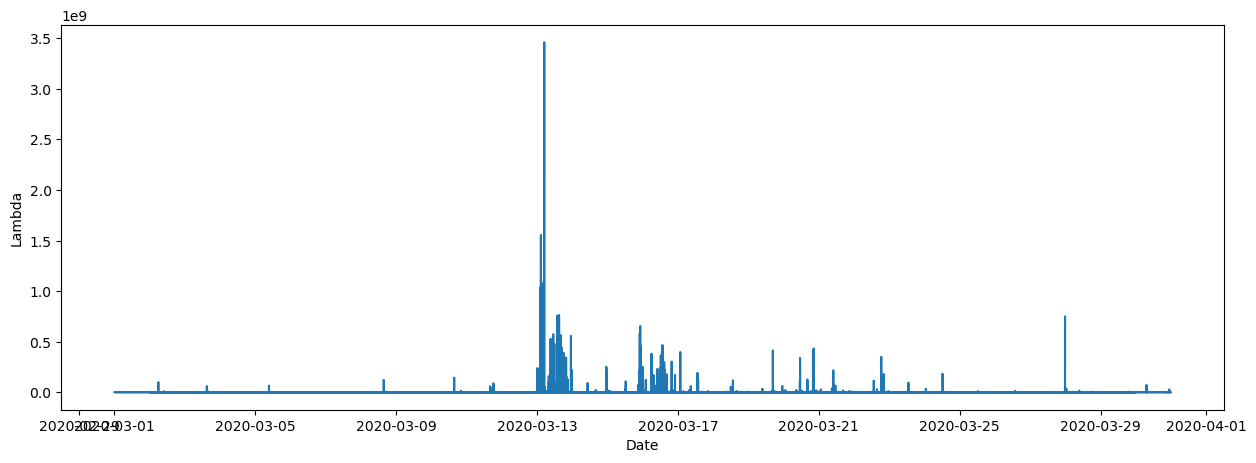

In [55]:
# Convert date columns to date
bitcoin_df['time_exchange'] = pd.to_datetime(bitcoin_df['time_exchange'])
bitcoin_df['time_coinapi'] = pd.to_datetime(bitcoin_df['time_coinapi'])

# Set index
bitcoin_df.set_index('time_exchange', inplace=True)

# Plot March lambda
plt.figure(figsize=(15,5))
plt.plot(bitcoin_df.index, bitcoin_df['lambda'], label='Lambda')
plt.xlabel('Date')
plt.ylabel('Lambda')
plt.show()

In [56]:
# Get price impact
bitcoin_df['Price Impact'] = (bitcoin_df['price'].shift(1) - bitcoin_df['price'])/bitcoin_df['base_amount']

In [57]:
# Calculate the return
bitcoin_df['Return'] = bitcoin_df['price'].pct_change()

In [59]:
# Supress warnings for future use
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Get signed volume
bitcoin_df['numeric_taker_side'] = bitcoin_df['taker_side'].apply(lambda x: 1 if x == 'BUY' else -1)
bitcoin_df['signed_volume'] = bitcoin_df['base_amount'] * bitcoin_df['numeric_taker_side']

# Create new list for daily and hourly values
daily_bitcoin_df = pd.DataFrame()
hourly_bitcoin_df = pd.DataFrame()

# Calculate values on a daily basis
for name, group in bitcoin_df.groupby(pd.Grouper(freq='D')):
    volume = group['base_amount'].sum()
    signed_volume = group['signed_volume'].sum()
    vwap = (group['price'] * group['base_amount']).sum() / group['base_amount'].sum()
    price = group['price'].mean()
    kyles_lambda = group['lambda'].mean()
    price_impact = group['Price Impact'].sum()
    my_return = group['Return'].sum()

    # Add values to the dataframe
    daily_bitcoin_df = daily_bitcoin_df.append({
        'Date': name,
        'Volume': volume,
        'Signed Volume': signed_volume,
        'VWAP': vwap,
        'Price': price,
        'Lambda': kyles_lambda,
        'Price Impact': price_impact,
        'Return': my_return
    }, ignore_index = True)
    
daily_bitcoin_df.head(5)

,Date,Volume,Signed Volume,VWAP,Price,Lambda,Price Impact,Return
0,2020-03-01,7353.139605,670.057258,8549.464432,8549.104019,167.744675,1.078363e+06,0.060776
1,2020-03-02,10216.692545,1017.293502,8772.556464,8771.874792,1864.348493,1.124561e+08,-0.015027
2,2020-03-03,9152.706926,-72.819076,8774.882854,8778.829091,1656.394232,7.821047e+07,0.315094
3,2020-03-04,5688.585097,-53.073086,8755.681862,8758.051194,121.277132,5.542319e+05,0.000550
4,2020-03-05,10073.314212,1003.244877,9025.289703,9025.864126,1226.571195,6.645239e+07,0.034933


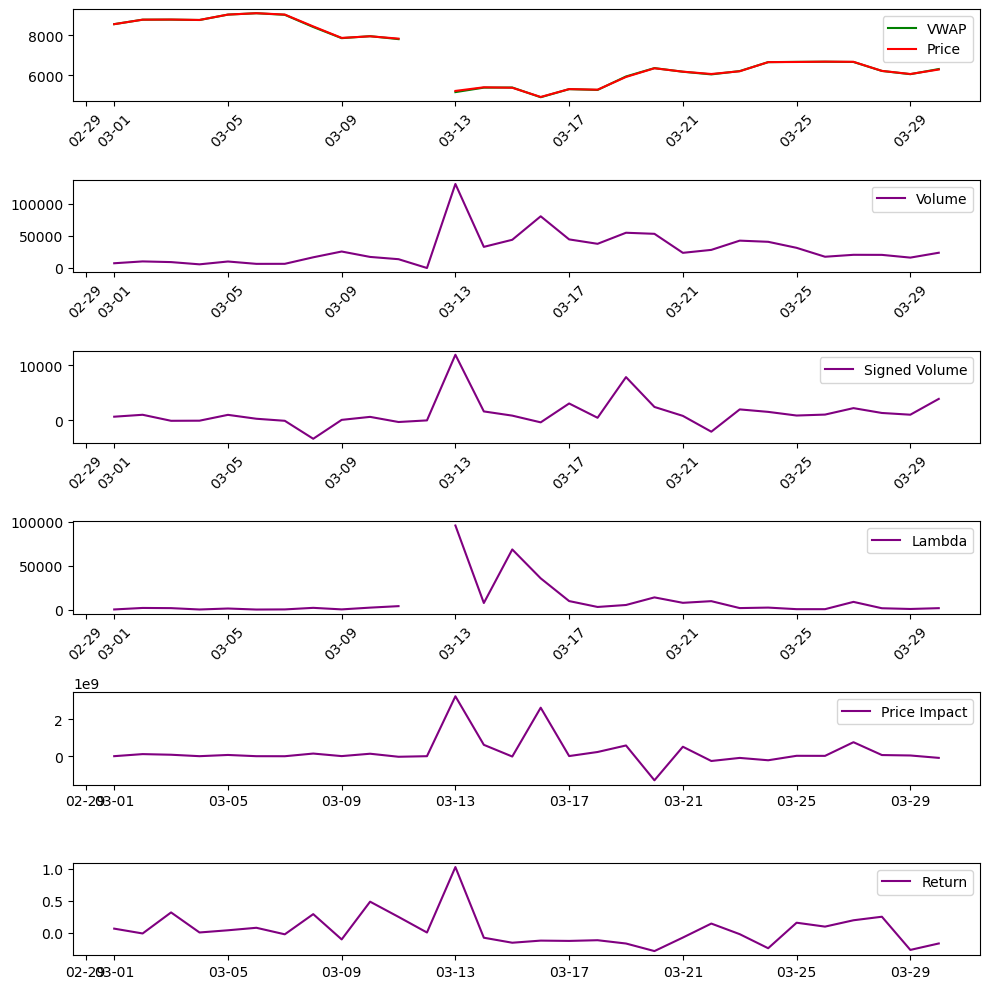

In [61]:
# Create plots for each column against date
fig, axs = plt.subplots(6, 1, figsize=(10,10))
axs[0].plot(daily_bitcoin_df['Date'], daily_bitcoin_df['VWAP'], label='VWAP', color='green')
axs[0].plot(daily_bitcoin_df['Date'], daily_bitcoin_df['Price'], label='Price', color='red')

axs[1].plot(daily_bitcoin_df['Date'], daily_bitcoin_df['Volume'], label='Volume', color='purple')

axs[2].plot(daily_bitcoin_df['Date'], daily_bitcoin_df['Signed Volume'], label='Signed Volume', color='purple')

axs[3].plot(daily_bitcoin_df['Date'], daily_bitcoin_df['Lambda'], label='Lambda', color='purple')

axs[4].plot(daily_bitcoin_df['Date'], daily_bitcoin_df['Price Impact'], label='Price Impact', color='purple')

axs[5].plot(daily_bitcoin_df['Date'], daily_bitcoin_df['Return'], label='Return', color='purple')

# Code Credit ChatGPT
date_form = mdates.DateFormatter("%m-%d")
for ax in axs.flat:
    ax.xaxis.set_major_formatter(date_form)
    ax.legend()

# Rotate date labels for clarity
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [63]:
# Repeat the same process for daily values
for name, group in bitcoin_df.groupby(pd.Grouper(freq='H')):
    volume = group['base_amount'].sum()
    signed_volume = group['signed_volume'].sum()
    vwap = (group['price'] * group['base_amount']).sum() / group['base_amount'].sum()
    price = group['price'].mean()
    kyles_lambda = group['lambda'].mean()
    price_impact = group['Price Impact'].sum()
    my_return = group['Return'].sum()
    
    hourly_bitcoin_df = hourly_bitcoin_df.append({
        'Date': name,
        'Volume': volume,
        'Signed Volume': signed_volume,
        'VWAP': vwap,
        'Price': price,
        'Lambda': kyles_lambda,
        'Price Impact': price_impact,
        'Return': my_return
    }, ignore_index=True)

hourly_bitcoin_df.head(5)

,Date,Volume,Signed Volume,VWAP,Price,Lambda,Price Impact,Return
0,2020-03-01 00:00:00,514.619429,45.744323,8567.692894,8571.759153,141.768492,-68810.880109,0.062379
1,2020-03-01 01:00:00,391.800589,-9.060931,8560.983080,8566.824289,175.472037,-329177.041328,0.011693
2,2020-03-01 02:00:00,248.169058,2.646862,8637.702911,8637.605797,89.949865,-23732.405823,-0.001379
3,2020-03-01 03:00:00,266.848771,-13.897015,8629.865826,8635.287055,61.380060,-29966.972884,-0.001920
4,2020-03-01 04:00:00,305.307608,-8.713283,8580.148682,8585.868744,52.843142,10128.783972,-0.003894


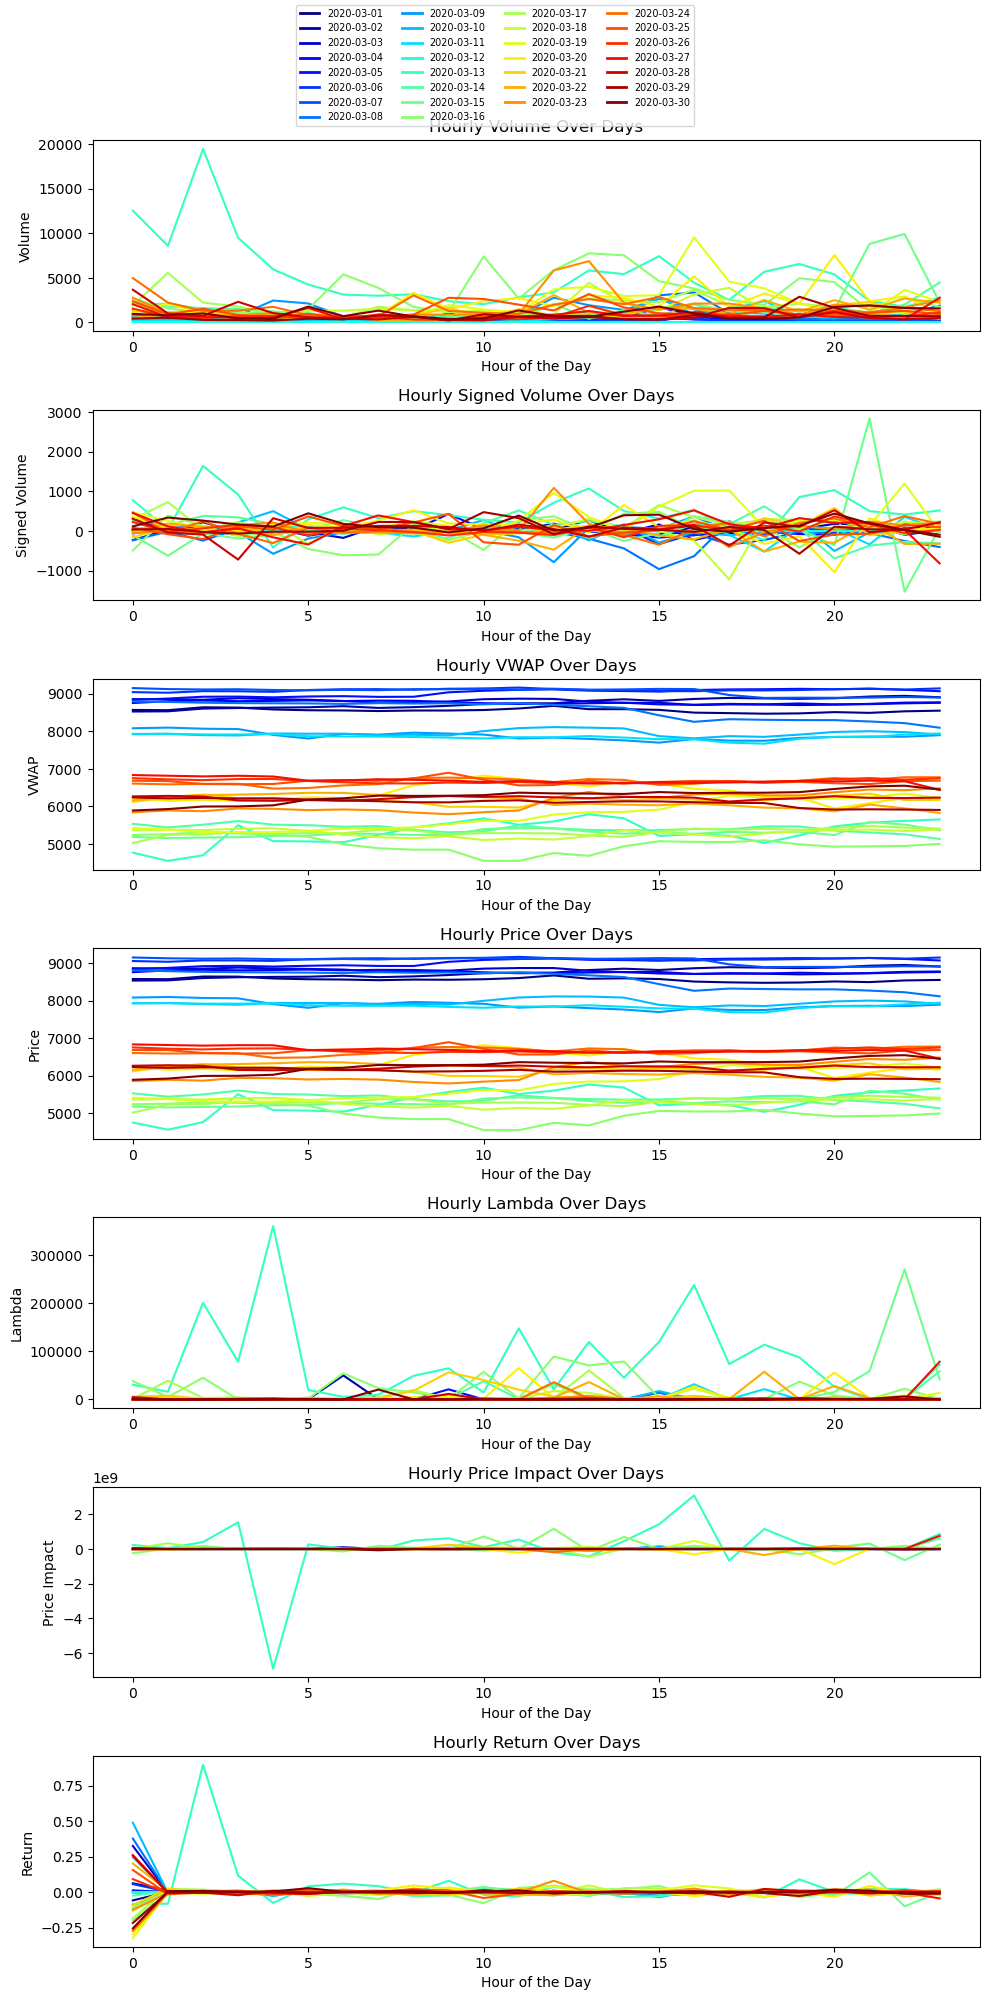

In [71]:
# Set new index 
#hourly_bitcoin_df.set_index('Date', inplace=True)

# Plate hourly values, day on day
dates = hourly_bitcoin_df.index.normalize().unique()
colors = plt.cm.jet(np.linspace(0, 1, len(dates)))

# Create plots
fig, axs = plt.subplots(7, 1, figsize=(10, 20))  # One subplot for each value

for i, col in enumerate(['Volume', 'Signed Volume', 'VWAP', 'Price', 'Lambda', 'Price Impact', 'Return']):
    # Plot each day with a unique color
    for date, color in zip(dates, colors):
        daily_data = hourly_bitcoin_df[hourly_bitcoin_df.index.date == date.date()]
        axs[i].plot(daily_data.index.hour, daily_data[col], label=date.strftime('%Y-%m-%d'), color=color)

    axs[i].set_title(f'Hourly {col} Over Days')
    axs[i].set_xlabel('Hour of the Day')
    axs[i].set_ylabel(col)

handles = [plt.Line2D([0], [0], color=color, lw=2) for color in colors]
labels = [date.strftime('%Y-%m-%d') for date in dates]
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize='x-small')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to fit the custom legend
plt.show()

Based on the graphs, we can say that the huge price changes (price drop around 3/13) reflect in more variance. We can see how blue (beginning of the month) and red (end of the month) graphs don't have much variance and tend to stay around the same level in every metric, which the green yellow are more volatile and also have much higher lambda. 

In [72]:
# Get signed lambda 
bitcoin_df['Signed Lambda'] = bitcoin_df['lambda'] * bitcoin_df['numeric_taker_side']
bitcoin_df.head(5)

,time_coinapi,guid,price,base_amount,taker_side,lambda,Price Impact,Return,numeric_taker_side,signed_volume,Signed Lambda
time_exchange,,,,,,,,,,,
2020-03-07 00:00:00.412262,2020-03-07 00:00:00.474868600,6131eff3-d0c4-46c6-9ce0-dee7f12eb56e,9158.51,0.017000,BUY,NaN,NaN,NaN,1,0.017000,NaN
2020-03-07 00:00:00.426306,2020-03-07 00:00:00.490359800,1b95b626-9a8c-4e37-ab7f-a759caee1706,9158.51,0.020000,BUY,0.0,0.0,0.0,1,0.020000,0.0
2020-03-07 00:00:02.129384,2020-03-07 00:00:02.191277400,706b9548-901a-492d-85e8-0ca748d87f93,9158.51,0.031866,BUY,0.0,0.0,0.0,1,0.031866,0.0
2020-03-07 00:00:02.754331,2020-03-07 00:00:02.819326400,b0dbad26-7915-481c-b536-6d70b7f6f246,9158.51,0.004999,BUY,0.0,0.0,0.0,1,0.004999,0.0
2020-03-07 00:00:04.425490,2020-03-07 00:00:04.505197600,596ee51a-8907-4494-9560-50442f9e2e0c,9158.51,0.001468,BUY,0.0,0.0,0.0,1,0.001468,0.0


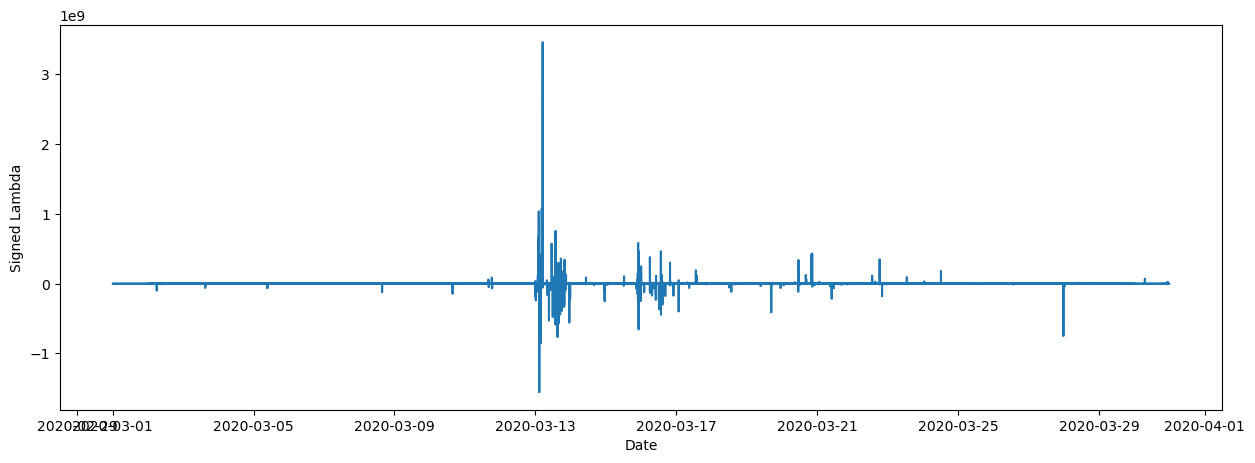

In [74]:
plt.figure(figsize=(15, 5))
plt.plot(bitcoin_df.index, bitcoin_df['Signed Lambda'], label='Signed Lambda')
plt.xlabel('Date')
plt.ylabel('Signed Lambda')
plt.show()

In [2]:
# Assign trading side

# Calculate trading signed trading volume (buy - sell)

# Calcuate return

#### Calculate price impact 
Note that price impact means price movement due to 1 dollar of trade of 1 share of trade.
Question, why is it better to define price impact using $\Delta p$ of trader than $\Delta p$ share of trade? 


##### Overall price impact

##### Price impact by hour
This requires to first aggregate data to data/hour level 

##### Forecasting Power of lambda
Try signed lambda 


#### Trading Strategy based on Signed lambda

According to the information it seems like it makes sense to go with the market, meaning we buy when lambda is positive and sell when the lambda is negative.